# **Predicción de supervivencia post-transplante de células HCT**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [24]:
# === 1. Cargar datos ===
df = pd.read_csv("data.csv")
print('Tamaño del dataset:', df.shape)
print('Información general del dataset:')
df.info()

Tamaño del dataset: (28800, 60)
Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26

In [25]:
print('Valores nulos del dataset por columnas:')

missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100
missing_values_percentage

print('Mayor porcentaje de valores nulos:', missing_values_percentage.max())

Valores nulos del dataset por columnas:
Mayor porcentaje de valores nulos: 65.95833333333333


In [26]:
# === 2. Limpieza inicial ===
#Eliminamos aquellas columnas que tienen más de un 30% de valores nulos
#Eliminamos las columnas 'ID' y 'efs_time'
missing = df.isnull().mean() * 100
cols_to_drop = missing[missing > 30].index.tolist()
df = df.drop(columns=cols_to_drop)
df = df.drop(columns=[col for col in ['ID', 'efs_time'] if col in df.columns])
df.shape

(28800, 53)

In [27]:
# === 3. Split ===
X = df.drop(columns='efs')
y = df['efs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:

# === 4. Funciones de transformación ===
def transformar_variables(df):
    df = df.copy()

   # --- dri_score-- 
    map_dri = {
        'High': 'High', 
        'Intermediate - TED AML case <missing cytogenetics': 'Intermediate',
        'TBD cytogenetics': 'Unknown',
        'Intermediate': 'Intermediate',
        'N/A - non-malignant indication': 'N/A', 
        'Low': 'Low',
        'N/A - pediatric': 'N/A', 
        'High - TED AML case <missing cytogenetics':'High',
        'N/A - disease not classifiable': 'N/A', 
        'Very high': 'High',
        'Missing disease status': 'Unknown', 
        'N/A': 'N/A', 'Unknown':'Unknown'}
    df['dri_score'] = df['dri_score'].replace(map_dri).fillna('Unknown')

    # --- pysch_disturb-- 
    df['psych_disturb'] = df['psych_disturb'].replace({'Not done': 'No'}).fillna('No')

    # --- cyto_score ---
    map_cyto = {
        'Favorable': 'Favorable', 
        'Intermediate': 'Intermediate', 
        'Poor': 'Poor',
        'Normal': 'Intermediate', 
        'Other': 'Intermediate', 
        'TBD': 'Unknown', 
        'Not tested': 'Unknown'}
    df['cyto_score'] = df['cyto_score'].replace(map_cyto).fillna('Unknown')

    # --- diabetes ---
    df['diabetes'] = df['diabetes'].replace({'Not done': 'No'}).fillna('No')
    
    # --- arrhytmia ---
    df['arrhythmia'] = df['arrhythmia'].replace({'Not done': 'No'}).fillna('No')

    # --- tbi_status ---
    df['tbi_status'] = df['tbi_status'].apply(lambda x: 'TBI' if x != 'No TBI' else 'No TBI')

    bin_vars = ['renal_issue', 'pulm_severe', 'hepatic_severe', 'hepatic_mild', 'cardiac',
                'rheum_issue', 'prior_tumor', 'obesity', 'peptic_ulcer', 'pulm_moderate',
                'vent_hist', 'rituximab', 'in_vivo_tcd']
    for col in bin_vars:
        df[col] = df[col].replace({'Not done': 'No'}).fillna('No')

    # --- prim_disease_hct ---
    if 'prim_disease_hct' in df.columns:
        comunes = df['prim_disease_hct'].value_counts()[lambda x: x >= 1000].index
        df['prim_disease_hct'] = df['prim_disease_hct'].apply(lambda x: x if x in comunes else 'Other_disease')

    # --- conditioning_intensity ---
    if 'conditioning_intensity' in df.columns:
        df['conditioning_intensity'] = df['conditioning_intensity'].replace({
            'TBD': 'Unknown', 'No drugs reported': 'Unknown', 'N/A...': 'Unknown'}).fillna('Unknown')

    # --- donor_related ---
    if 'donor_related' in df.columns:
        df['donor_related'] = df['donor_related'].replace({'Multiple donor (non-UCB)': 'Unrelated'})

    # --- gvhd_proph --
    def agrupar_gvhd(valor):
        if pd.isna(valor): return 'Other'
        valor = valor.lower()
        if 'fk' in valor: return 'FK-based'
        elif 'csa' in valor: return 'CSA-based'
        elif 'cyclophosphamide' in valor: return 'Cyclophosphamide-based'
        elif 'tdepletion' in valor: return 'TDEPLETION-based'
        elif 'cdselect' in valor: return 'CDselect-based'
        elif 'mmf' in valor or 'mtx' in valor: return 'MMF/MTX-based'
        elif 'prophylaxis' in valor or 'no agent' in valor: return 'Other'
        else: return 'Other'

    if 'gvhd_proph' in df.columns:
        df['gvhd_proph'] = df['gvhd_proph'].apply(agrupar_gvhd)

    ### -- Columnas con registros vacios -- 
    # 1. Imputación para variables numéricas con el valor más repetido
    columnas_hla = ['hla_match_c_high', 'hla_high_res_8', 'hla_high_res_6', 'hla_high_res_10',
                    'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_a_high', 'hla_match_b_high',
                    'hla_match_drb1_high']
    for col in columnas_hla:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode(dropna=True)[0])

    # 2. Imputación para variables numéricas con media entera
    for col in ['donor_age', 'comorbidity_score', 'karnofsky_score']:
        if col in df.columns:
            df[col] = df[col].fillna(int(round(df[col].mean(skipna=True))))

    # 3. Eliminación de variables no informativas o redundantes ---
    columnas_a_eliminar = [
        'hla_low_res_6','hla_match_c_low', 'hla_match_drb1_low',
        'hla_match_dqb1_low','hla_match_b_low','hla_match_a_low',
        'hla_low_res_8','hla_low_res_10'
    ]
    columnas_a_eliminar_existentes = [col for col in columnas_a_eliminar if col in df.columns]
    df = df.drop(columns=columnas_a_eliminar_existentes)
    return df

def transformar_variables2(df):
    var_eliminar = ['hla_match_c_high','hla_high_res_6','hla_high_res_10', 
                    'hla_match_dqb1_high', 'hla_nmdp_6', 'rituximab',
                    'year_hct','hla_match_a_high','donor_age', 'peptic_ulcer',
                    'hla_match_b_high', 'hepatic_mild','hla_match_drb1_high']
    existentes = [col for col in var_eliminar if col in df.columns]
    return df.drop(columns=existentes)

# === 5. Preprocesamiento seguro ===
def codificar_variables(df, encoder=None, fit=True):
    df = df.copy()

    # --- 1. Codificación de variables ordinales ---
    ordinal_mappings = {
        'dri_score': {'Low': 1, 'Intermediate': 2, 'High': 3, 'N/A': 0, 'Unknown': -1},
        'cyto_score': {'Favorable': 1, 'Intermediate': 2, 'Poor': 3, 'Unknown': -1}}
    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    # --- 2. Codificación de variables binarias (Yes/No) ---
    bin_cols = [col for col in df.columns
                if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({'Yes', 'No'})]
    for col in bin_cols:
        df[col] = df[col].map({'No': 0, 'Yes': 1})

    # --- 3. Codificación One-Hot de variables categóricas nominales ---
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    cat_cols = [col for col in cat_cols if col not in ordinal_mappings and col not in bin_cols]

    if cat_cols:
        if fit:
            encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
            encoded = encoder.fit_transform(df[cat_cols])
        else:
            encoded = encoder.transform(df[cat_cols])

        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols), index=df.index)
        df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

    return df, encoder

def normalizar_datos(df, scaler=None, fit=True):
    df = df.copy()
    columnas = df.select_dtypes(include='number').columns.tolist()
    if fit:
        scaler = StandardScaler()
        df[columnas] = scaler.fit_transform(df[columnas])
    else:
        df[columnas] = scaler.transform(df[columnas])
    return df, scaler

def procesamiento_datos_entrenamiento(df):
    df = transformar_variables(df)
    df = transformar_variables2(df)
    df, encoder = codificar_variables(df, fit=True)
    df, scaler = normalizar_datos(df, fit=True)
    return df, encoder, scaler

def procesamiento_datos_test(df, encoder, scaler):
    df = transformar_variables(df)
    df = transformar_variables2(df)
    df, _ = codificar_variables(df, encoder=encoder, fit=False)
    df, _ = normalizar_datos(df, scaler=scaler, fit=False)
    return df


In [29]:
# === 6. Entrenamiento ===
X_train_proc, encoder, scaler = procesamiento_datos_entrenamiento(X_train)
X_test_proc = procesamiento_datos_test(X_test, encoder, scaler)
X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

In [30]:
def entrenar_y_evaluar_modelos(X_train, X_test, y_train, y_test):
    """
    Entrena y evalúa modelos de ML: LogReg, RandomForest, GradientBoosting, SVM, KNN, NaiveBayes.
    Devuelve un DataFrame ordenado por F1-score.
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    import pandas as pd

    resultados = []

    # ==== LOGISTIC REGRESSION ====
    for C in [0.01, 0.1, 1, 10]:
        modelo = LogisticRegression(C=C, max_iter=1000, solver='newton-cg', random_state=42)
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)[:, 1]
        resultados.append({
            'Modelo': f'LogReg (C = {C})',
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_proba)
        })

    # ==== RANDOM FOREST ====
    for n in [100, 200]:
        for d in [None, 10, 20]:
            modelo = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            y_proba = modelo.predict_proba(X_test)[:, 1]
            resultados.append({
                'Modelo': f'RF (n={n}, depth={d})',
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1': f1_score(y_test, y_pred),
                'AUC': roc_auc_score(y_test, y_proba)
            })

    # ==== GRADIENT BOOSTING ====
    for lr in [0.01, 0.1, 0.2]:
        for n in [100, 200]:
            modelo = GradientBoostingClassifier(learning_rate=lr, n_estimators=n, random_state=42)
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            y_proba = modelo.predict_proba(X_test)[:, 1]
            resultados.append({
                'Modelo': f'GB (lr={lr}, n={n})',
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1': f1_score(y_test, y_pred),
                'AUC': roc_auc_score(y_test, y_proba)
            })

    # ==== SVM ====
    for C in [0.1, 1, 10]:
        modelo = SVC(C=C, kernel='linear', probability=True, random_state=42)
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)[:, 1]
        resultados.append({
            'Modelo': f'SVM (C={C})',
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_proba)
        })

    # ==== KNN ====
    for k in [3, 5, 7, 9]:
        modelo = KNeighborsClassifier(n_neighbors=k)
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)[:, 1]
        resultados.append({
            'Modelo': f'KNN (k={k})',
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_proba)
        })

    # ==== NAIVE BAYES ====
    modelo = GaussianNB()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    resultados.append({
        'Modelo': 'Naive Bayes',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

    resultados_df = pd.DataFrame(resultados).sort_values(by='F1', ascending=False).reset_index(drop=True)
    return resultados_df


In [31]:
# === 8. Evaluación ===
resultados = entrenar_y_evaluar_modelos(X_train_proc, X_test_proc, y_train, y_test)
display(resultados)

,Modelo,Accuracy,Precision,Recall,F1,AUC
0,"GB (lr=0.01, n=200)",0.657986,0.631441,0.864153,0.729693,0.711350
1,"GB (lr=0.01, n=100)",0.635243,0.606411,0.903802,0.725825,0.698982
2,"RF (n=200, depth=10)",0.672743,0.657090,0.810205,0.725659,0.719970
3,SVM (C=10),0.663715,0.644523,0.826129,0.724113,0.721329
4,SVM (C=1),0.663542,0.644433,0.825804,0.723932,0.721360
5,SVM (C=0.1),0.662674,0.643836,0.824829,0.723180,0.721287
6,"RF (n=100, depth=10)",0.668056,0.652687,0.809230,0.722577,0.719602
7,"GB (lr=0.1, n=100)",0.670312,0.666196,0.767306,0.713185,0.731178
8,"RF (n=200, depth=20)",0.668056,0.665436,0.761456,0.710215,0.721406
9,"GB (lr=0.1, n=200)",0.671701,0.674002,0.746506,0.708404,0.732270


Vemos que el modelo con el mejor rendimiento es:
*   GB (lr=0.1, n=200)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
🔍 F1 Score - Baseline (lr=0.1, n=200): 0.7084
🔎 F1 Score - Optimizado: 0.7089
📌 Hiperparámetros optimizados: {'n_estimators': np.int64(100), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': np.float64(0.13333333333333336)}


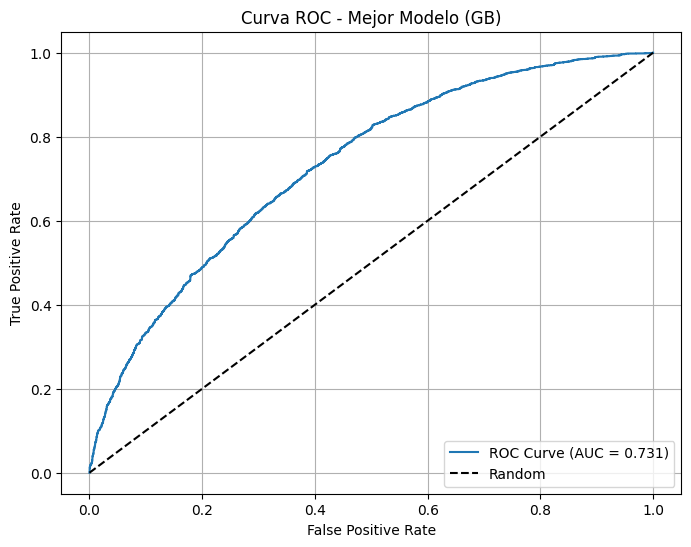

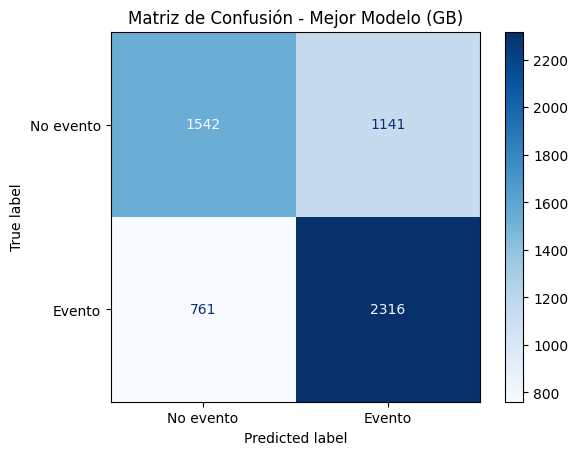

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import numpy as np

# Baseline
baseline_model = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)
baseline_model.fit(X_train_proc, y_train)
baseline_pred = baseline_model.predict(X_test_proc)
baseline_proba = baseline_model.predict_proba(X_test_proc)[:, 1]
baseline_f1 = f1_score(y_test, baseline_pred)

# Randomized search
param_dist = {
    'n_estimators': np.arange(100, 401, 50),
    'learning_rate': np.linspace(0.05, 0.2, 10),
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4]
}

random_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_proc, y_train)
best_model = random_search.best_estimator_
best_pred = best_model.predict(X_test_proc)
best_proba = best_model.predict_proba(X_test_proc)[:, 1]
best_f1 = f1_score(y_test, best_pred)

# Comparación
print("🔍 F1 Score - Baseline (lr=0.1, n=200):", round(baseline_f1, 4))
print("🔎 F1 Score - Optimizado:", round(best_f1, 4))
print("📌 Hiperparámetros optimizados:", random_search.best_params_)

final_model = best_model if best_f1 > baseline_f1 else baseline_model
final_pred = best_pred if best_f1 > baseline_f1 else baseline_pred
final_proba = best_proba if best_f1 > baseline_f1 else baseline_proba

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, final_proba)
roc_auc = roc_auc_score(y_test, final_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Mejor Modelo (GB)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Matriz de Confusión
cm = confusion_matrix(y_test, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No evento', 'Evento'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusión - Mejor Modelo (GB)')
plt.grid(False)
plt.show()


In [33]:
def representar_errores_por_categoria(X_original, y_real, y_pred, variable_categorica):
    """
    Representa la distribución de errores (TP, TN, FP, FN) por categoría de una variable.
    
    Parámetros:
    - X_original: DataFrame original (no preprocesado), debe contener la variable categórica.
    - y_real: Serie con las etiquetas verdaderas.
    - y_pred: Serie con las predicciones del modelo.
    - variable_categorica: string, nombre de la columna a analizar (e.g., 'ethnicity', 'sex').
    """
    df = X_original.copy()
    df['y_real'] = y_real
    df['y_pred'] = y_pred

    # Clasificación del tipo de error
    def clasificar_error(row):
        if row['y_real'] == 1 and row['y_pred'] == 1:
            return 'TP'
        elif row['y_real'] == 0 and row['y_pred'] == 0:
            return 'TN'
        elif row['y_real'] == 0 and row['y_pred'] == 1:
            return 'FP'
        elif row['y_real'] == 1 and row['y_pred'] == 0:
            return 'FN'

    df['tipo_error'] = df.apply(clasificar_error, axis=1)

    # Calcular proporciones por categoría
    error_count = df.groupby([variable_categorica, 'tipo_error']).size().reset_index(name='count')
    total_by_group = error_count.groupby(variable_categorica)['count'].transform('sum')
    error_count['proporcion'] = error_count['count'] / total_by_group

    # Gráfico
    plt.figure(figsize=(12, 6))
    sns.barplot(data=error_count, x=variable_categorica, y='proporcion', hue='tipo_error')
    plt.title(f'Proporción de tipos de error por grupo de "{variable_categorica}"')
    plt.ylabel('Proporción dentro del grupo')
    plt.xlabel(variable_categorica.capitalize())
    plt.ylim(0, 1)
    plt.legend(title='Tipo de predicción')
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


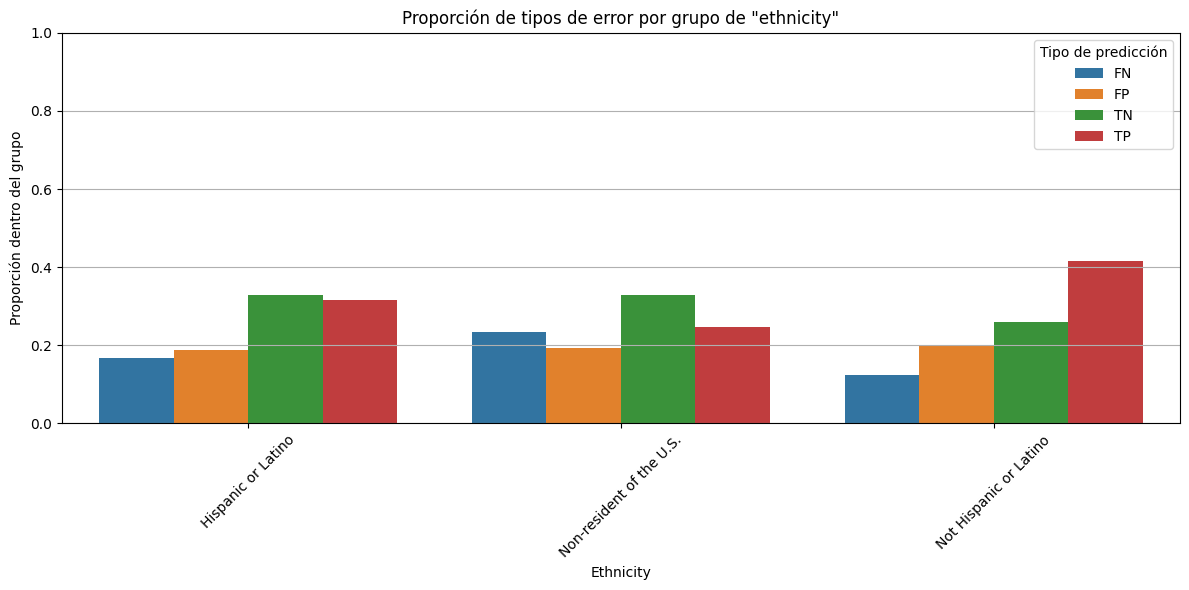

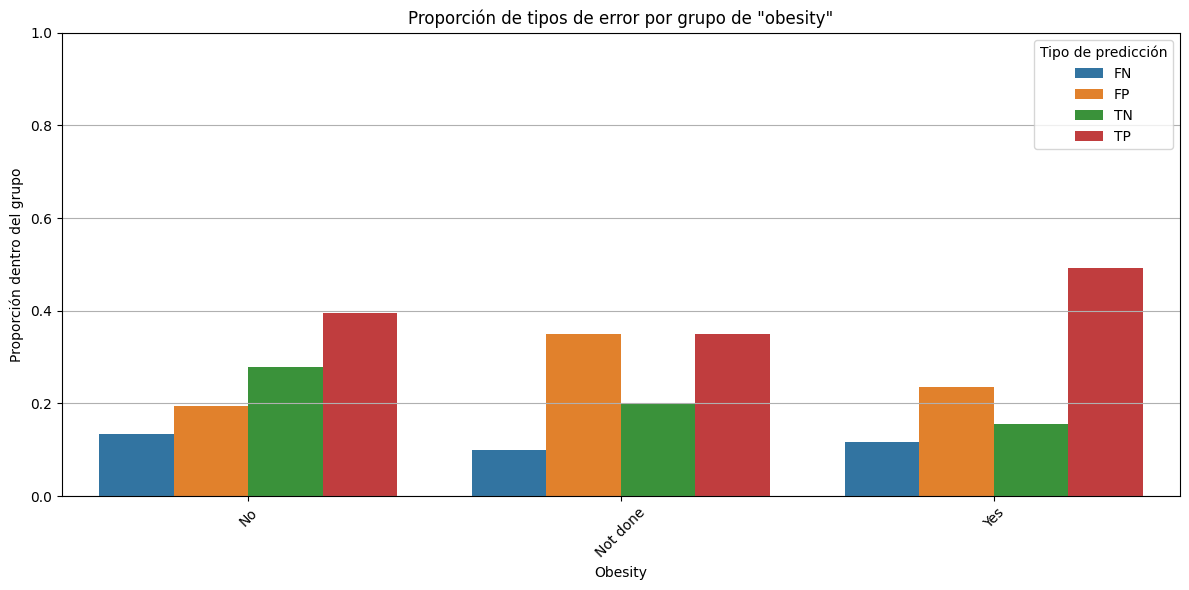

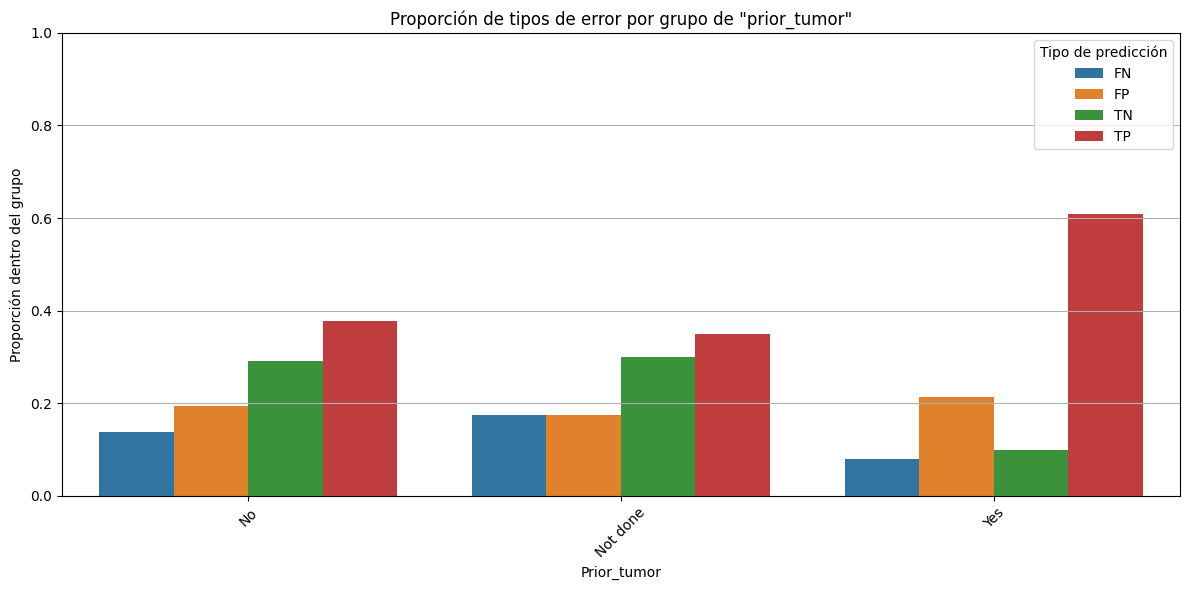

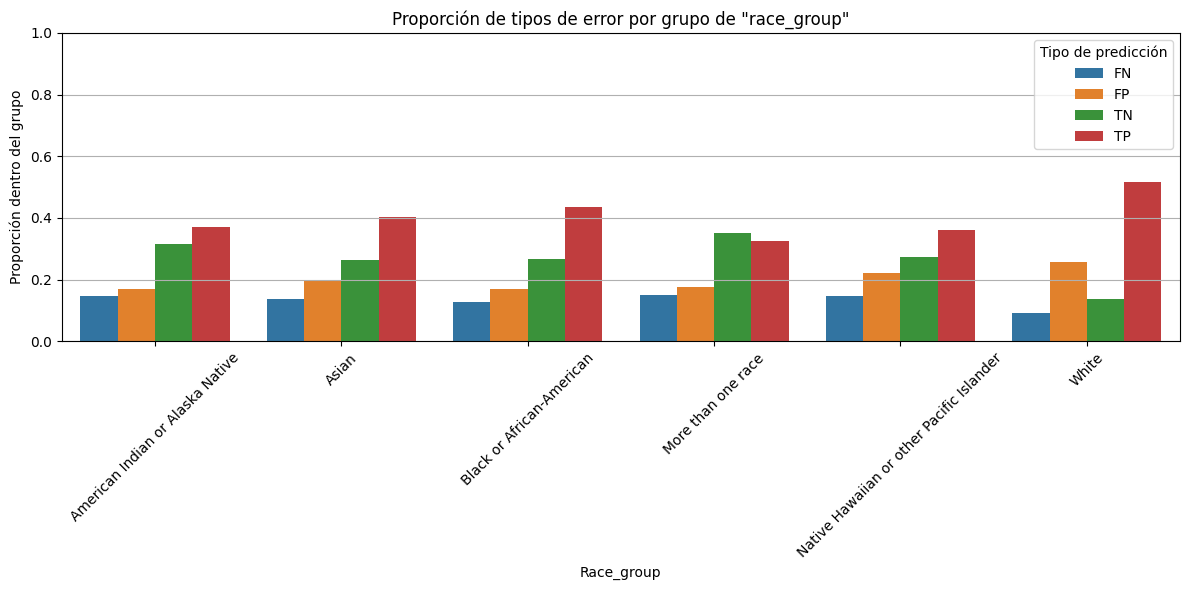

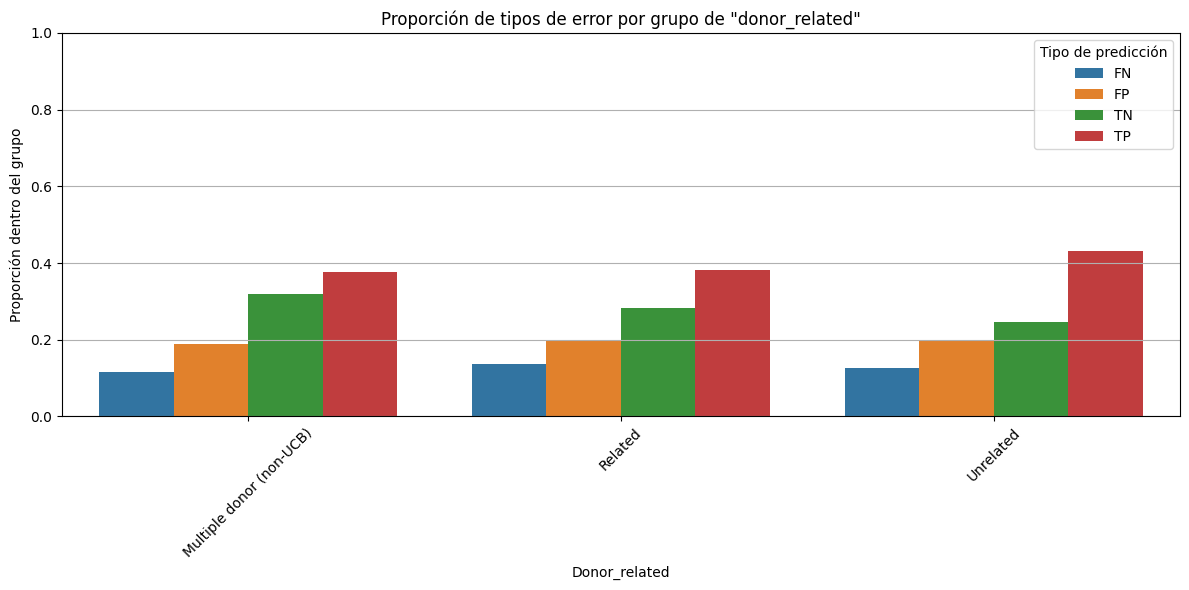

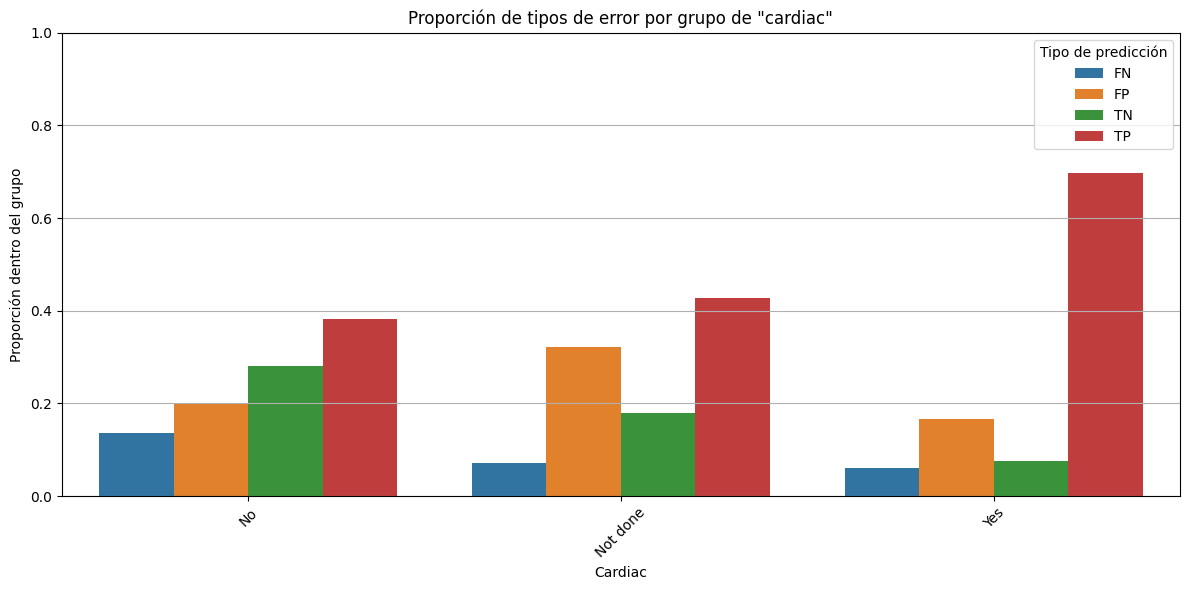

In [34]:
# Analizar errores por grupo étnico
representar_errores_por_categoria(X_test, y_test, final_pred, 'ethnicity')

# Analizar errores en función del peso del paciente.
representar_errores_por_categoria(X_test, y_test, final_pred, 'obesity')

# Analizar errores en función de si ha tenido un tumor previo.
representar_errores_por_categoria(X_test, y_test, final_pred, 'prior_tumor')

# Analizar errores en función de la raza del paciente
representar_errores_por_categoria(X_test, y_test, final_pred, 'race_group')

# Analizar errores en función de si el donante es familiar o no
representar_errores_por_categoria(X_test, y_test, final_pred, 'donor_related')

# Analizar errores en función de si el paciente tiene problemas cardiacos
representar_errores_por_categoria(X_test, y_test, final_pred, 'cardiac')


/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_90266/1757632428.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_count = df.groupby([variable_categorica, 'tipo_error']).size().reset_index(name='count')
/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_90266/1757632428.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_group = error_count.groupby(variable_categorica)['count'].transform('sum')


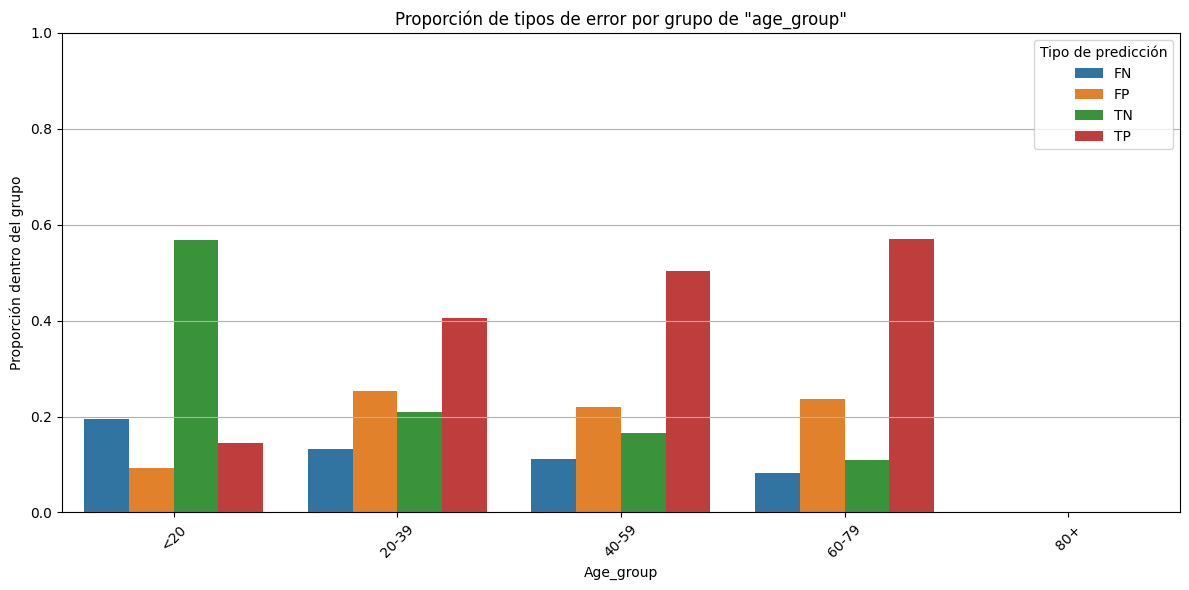

In [35]:
#Analizar en función de la edad del paciente
bins = [0, 20, 40, 60, 80, 100]
labels = ['<20', '20-39', '40-59', '60-79', '80+']
X_test['age_group'] = pd.cut(X_test['age_at_hct'], bins=bins, labels=labels, right=False)
representar_errores_por_categoria(X_test, y_test, final_pred, 'age_group')

* Modelo: RF (n=200, depth=10)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== Random Forest ===
🔍 F1 Score - Baseline (n=200, depth=10): 0.7257
🔎 F1 Score - Optimizado: 0.7245
📌 Hiperparámetros optimizados: {'n_estimators': np.int64(150), 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 10}


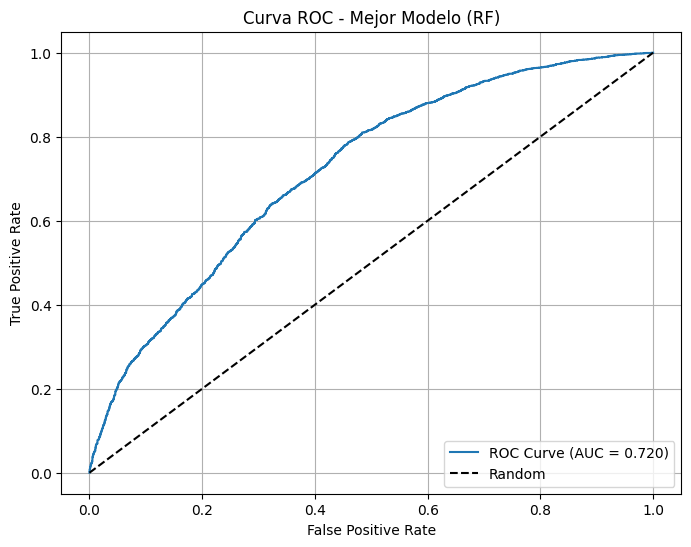

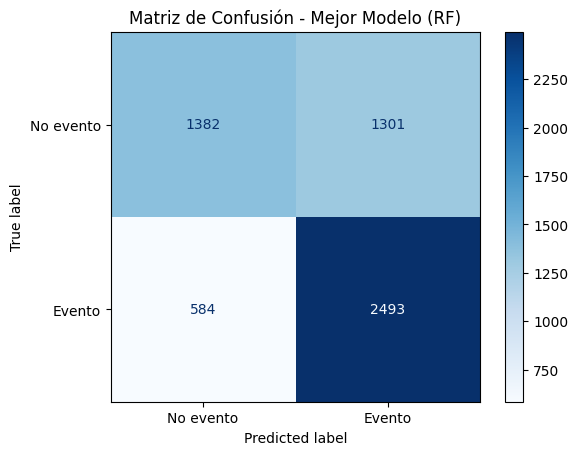

In [36]:
# Baseline
rf_baseline = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_baseline.fit(X_train_proc, y_train)
rf_pred = rf_baseline.predict(X_test_proc)
rf_proba = rf_baseline.predict_proba(X_test_proc)[:, 1]
rf_f1 = f1_score(y_test, rf_pred)

# Randomized Search para optimización
param_dist_rf = {
    'n_estimators': np.arange(100, 401, 50),
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=30,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_search.fit(X_train_proc, y_train)
rf_best_model = rf_search.best_estimator_
rf_best_pred = rf_best_model.predict(X_test_proc)
rf_best_proba = rf_best_model.predict_proba(X_test_proc)[:, 1]
rf_best_f1 = f1_score(y_test, rf_best_pred)

print("\n=== Random Forest ===")
print("🔍 F1 Score - Baseline (n=200, depth=10):", round(rf_f1, 4))
print("🔎 F1 Score - Optimizado:", round(rf_best_f1, 4))
print("📌 Hiperparámetros optimizados:", rf_search.best_params_)

rf_final_model = rf_best_model if rf_best_f1 > rf_f1 else rf_baseline
rf_final_pred = rf_best_pred if rf_best_f1 > rf_f1 else rf_pred
rf_final_proba = rf_best_proba if rf_best_f1 > rf_f1 else rf_proba

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_final_proba)
roc_auc_rf = roc_auc_score(y_test, rf_final_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'ROC Curve (AUC = {roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Mejor Modelo (RF)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

cm_rf = confusion_matrix(y_test, rf_final_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No evento', 'Evento'])
disp_rf.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusión - Mejor Modelo (RF)')
plt.grid(False)
plt.show()


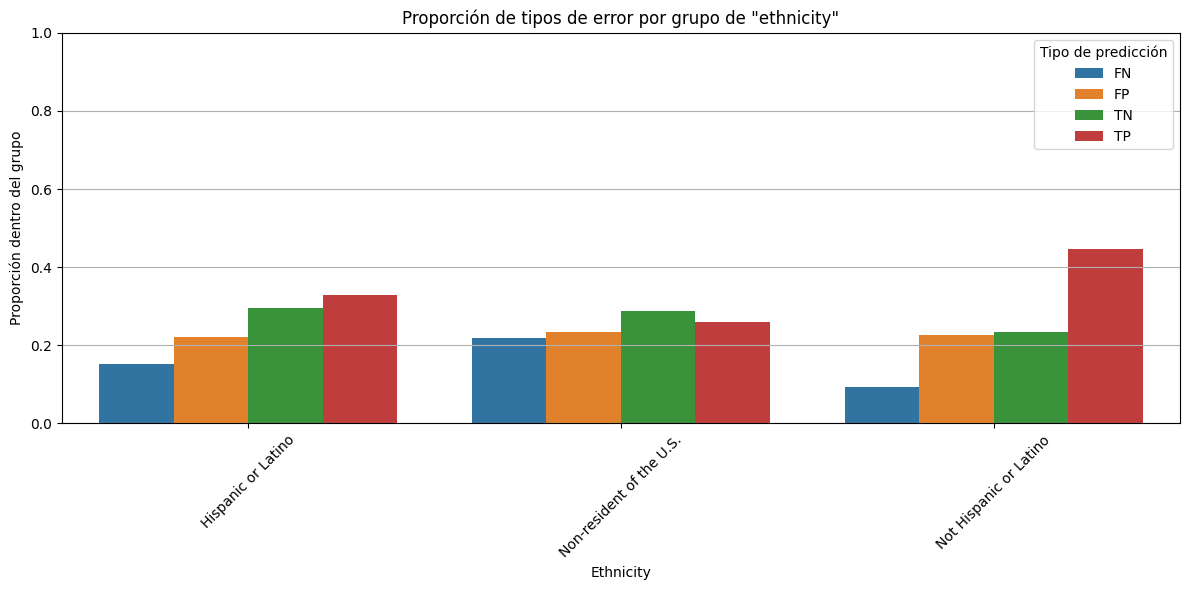

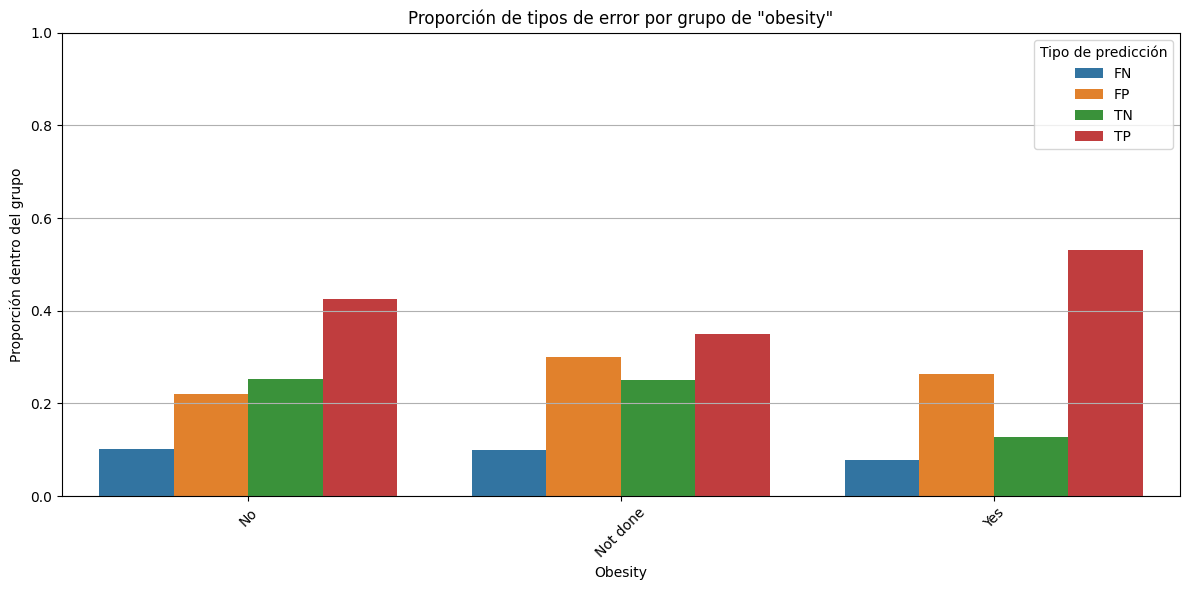

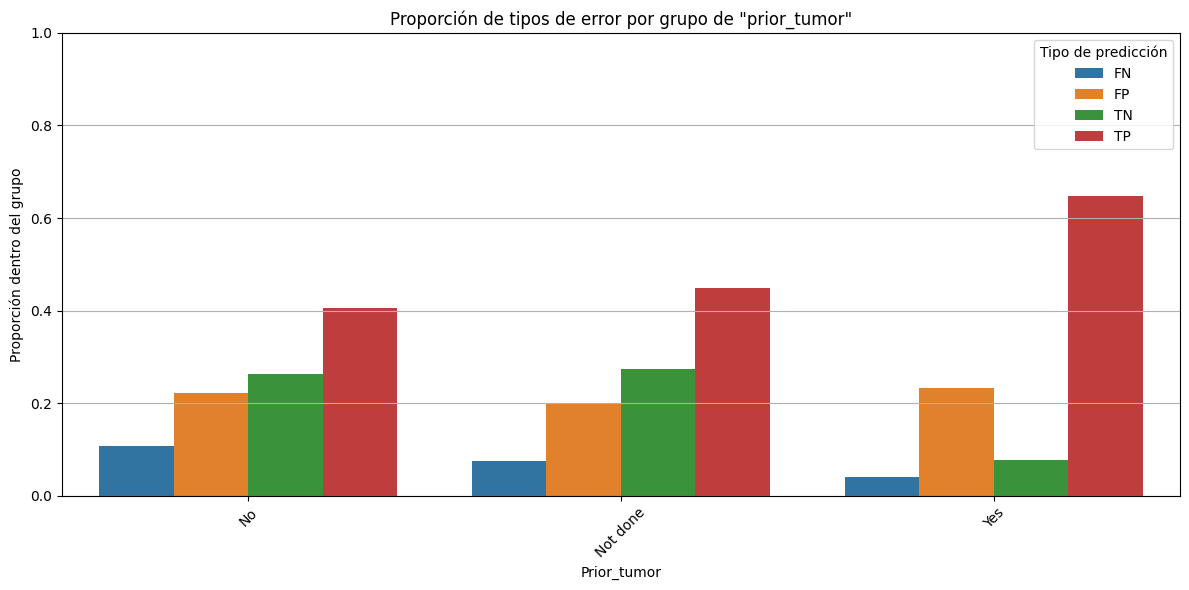

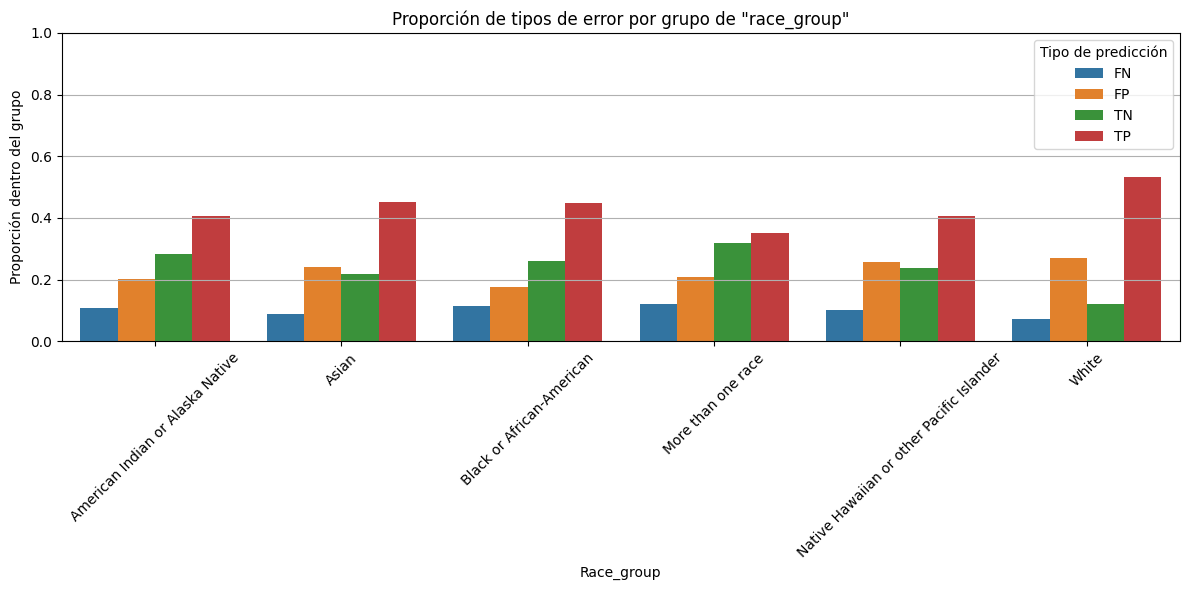

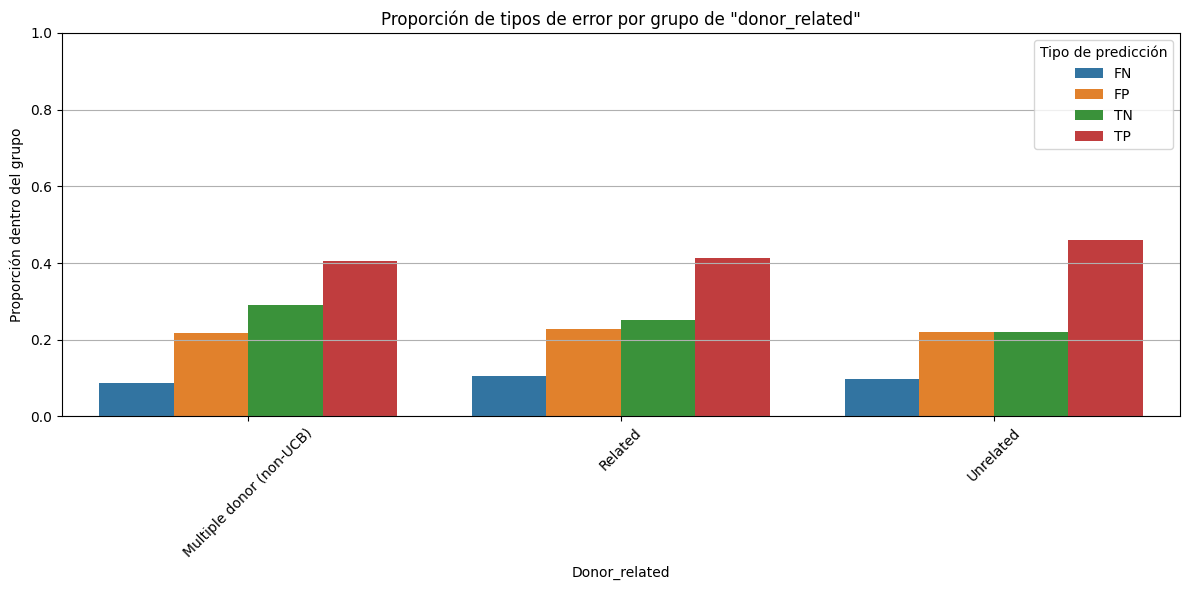

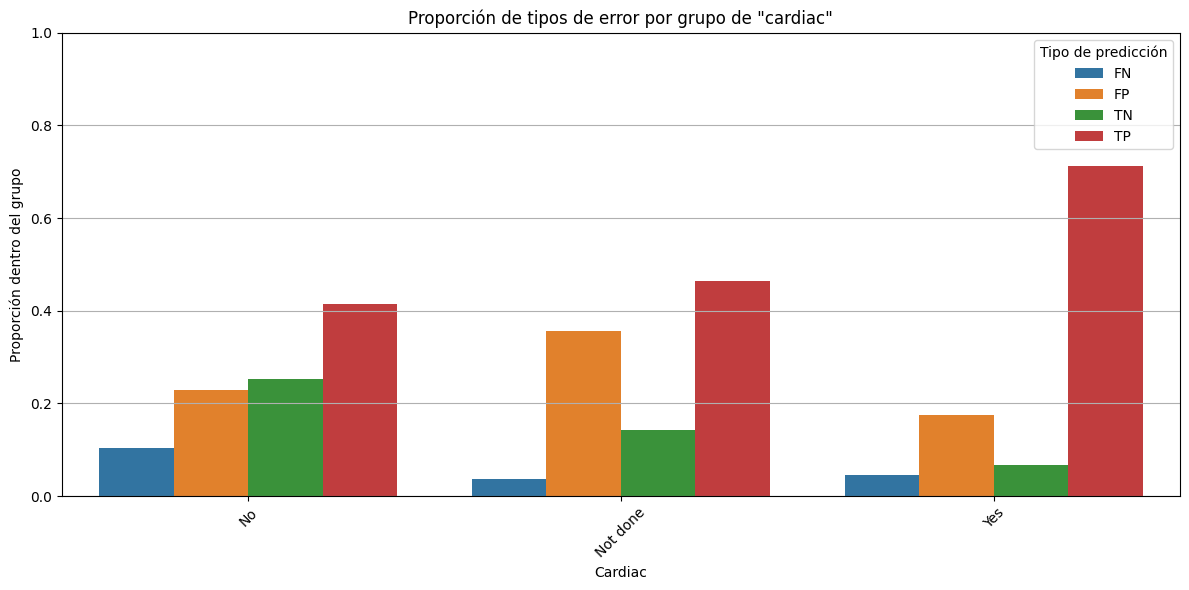

In [37]:
# Analizar errores por grupo étnico
representar_errores_por_categoria(X_test, y_test, rf_final_pred, 'ethnicity')

# Analizar errores en función del peso del paciente.
representar_errores_por_categoria(X_test, y_test, rf_final_pred, 'obesity')

# Analizar errores en función de si ha tenido un tumor previo.
representar_errores_por_categoria(X_test, y_test, rf_final_pred, 'prior_tumor')

# Analizar errores en función de la raza del paciente
representar_errores_por_categoria(X_test, y_test, rf_final_pred, 'race_group')

# Analizar errores en función de si el donante es familiar o no
representar_errores_por_categoria(X_test, y_test, rf_final_pred, 'donor_related')

# Analizar errores en función de si el paciente tiene problemas cardiacos
representar_errores_por_categoria(X_test, y_test, rf_final_pred, 'cardiac')


/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_90266/1757632428.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_count = df.groupby([variable_categorica, 'tipo_error']).size().reset_index(name='count')
/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_90266/1757632428.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_group = error_count.groupby(variable_categorica)['count'].transform('sum')


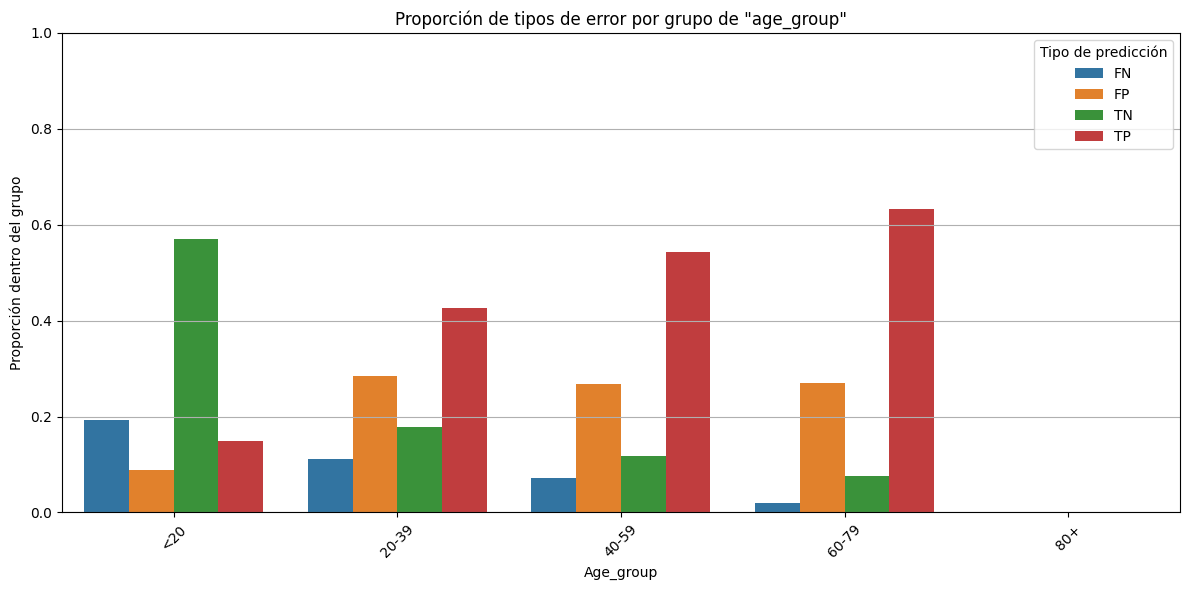

In [38]:
#Analizar en función de la edad del paciente
bins = [0, 20, 40, 60, 80, 100]
labels = ['<20', '20-39', '40-59', '60-79', '80+']
X_test['age_group'] = pd.cut(X_test['age_at_hct'], bins=bins, labels=labels, right=False)
representar_errores_por_categoria(X_test, y_test, rf_final_pred, 'age_group')

* Modelo: GB (lr=0.01, n=100)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== Gradient Boosting (lr=0.01, n=100) ===
🔍 F1 Score - Baseline (lr=0.01, n=100): 0.7258
🔎 F1 Score - Optimizado: 0.7316
📌 Hiperparámetros optimizados: {'n_estimators': np.int64(300), 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': np.float64(0.005)}


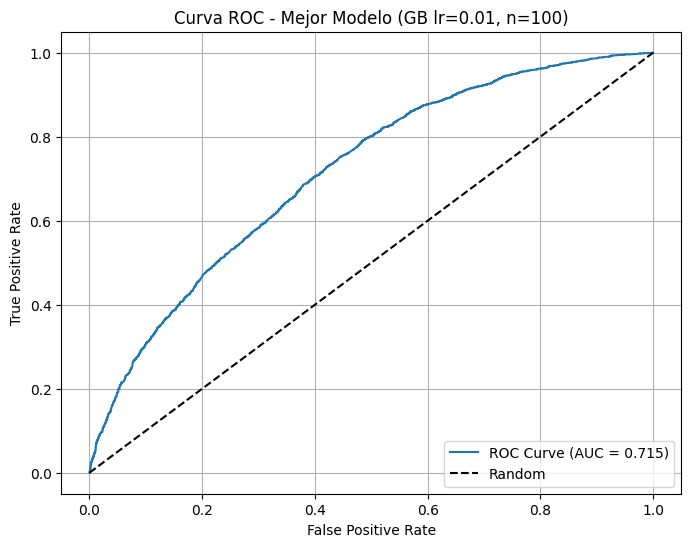

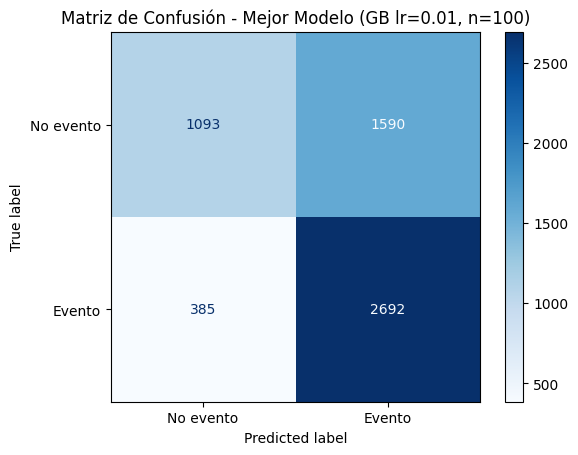

In [39]:
# === Comparativa: Modelo GB (lr=0.01, n=100) ===
from sklearn.ensemble import GradientBoostingClassifier

# Baseline
gb_baseline = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100, random_state=42)
gb_baseline.fit(X_train_proc, y_train)
gb_pred = gb_baseline.predict(X_test_proc)
gb_proba = gb_baseline.predict_proba(X_test_proc)[:, 1]
gb_f1 = f1_score(y_test, gb_pred)

# Randomized Search
param_dist_gb = {
    'n_estimators': np.arange(100, 401, 50),
    'learning_rate': np.linspace(0.005, 0.05, 10),
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4]
}

gb_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb,
    n_iter=30,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

gb_search.fit(X_train_proc, y_train)
gb_best_model = gb_search.best_estimator_
gb_best_pred = gb_best_model.predict(X_test_proc)
gb_best_proba = gb_best_model.predict_proba(X_test_proc)[:, 1]
gb_best_f1 = f1_score(y_test, gb_best_pred)

print("\n=== Gradient Boosting (lr=0.01, n=100) ===")
print("🔍 F1 Score - Baseline (lr=0.01, n=100):", round(gb_f1, 4))
print("🔎 F1 Score - Optimizado:", round(gb_best_f1, 4))
print("📌 Hiperparámetros optimizados:", gb_search.best_params_)

gb_final_model = gb_best_model if gb_best_f1 > gb_f1 else gb_baseline
gb_final_pred = gb_best_pred if gb_best_f1 > gb_f1 else gb_pred
gb_final_proba = gb_best_proba if gb_best_f1 > gb_f1 else gb_proba

fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_final_proba)
roc_auc_gb = roc_auc_score(y_test, gb_final_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, label=f'ROC Curve (AUC = {roc_auc_gb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Mejor Modelo (GB lr=0.01, n=100)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

cm_gb = confusion_matrix(y_test, gb_final_pred)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=['No evento', 'Evento'])
disp_gb.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusión - Mejor Modelo (GB lr=0.01, n=100)')
plt.grid(False)
plt.show()


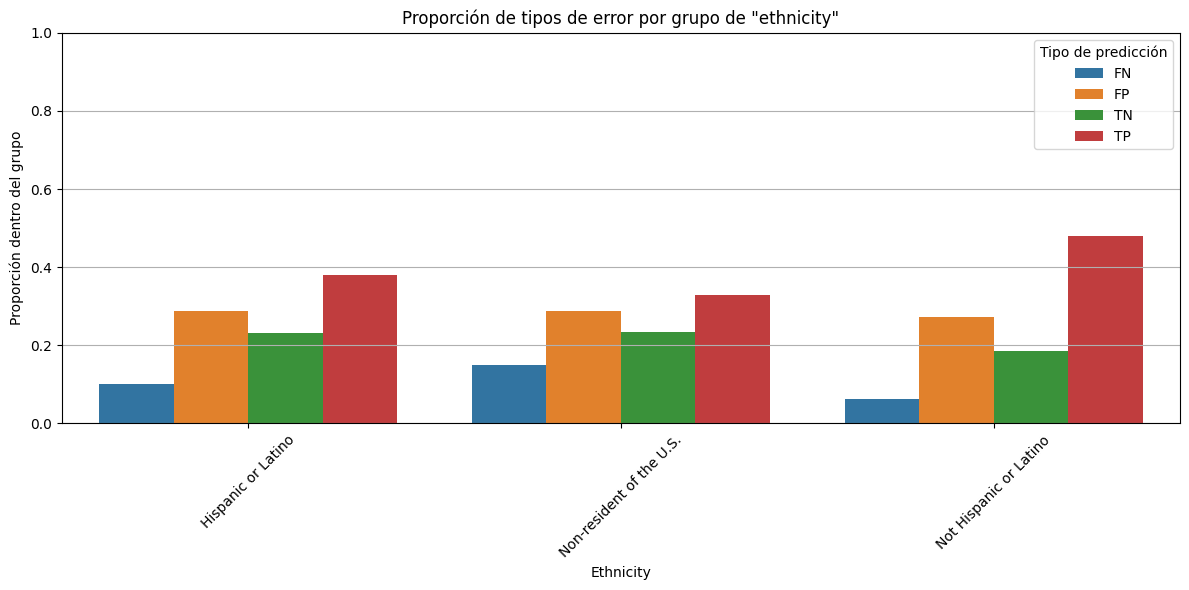

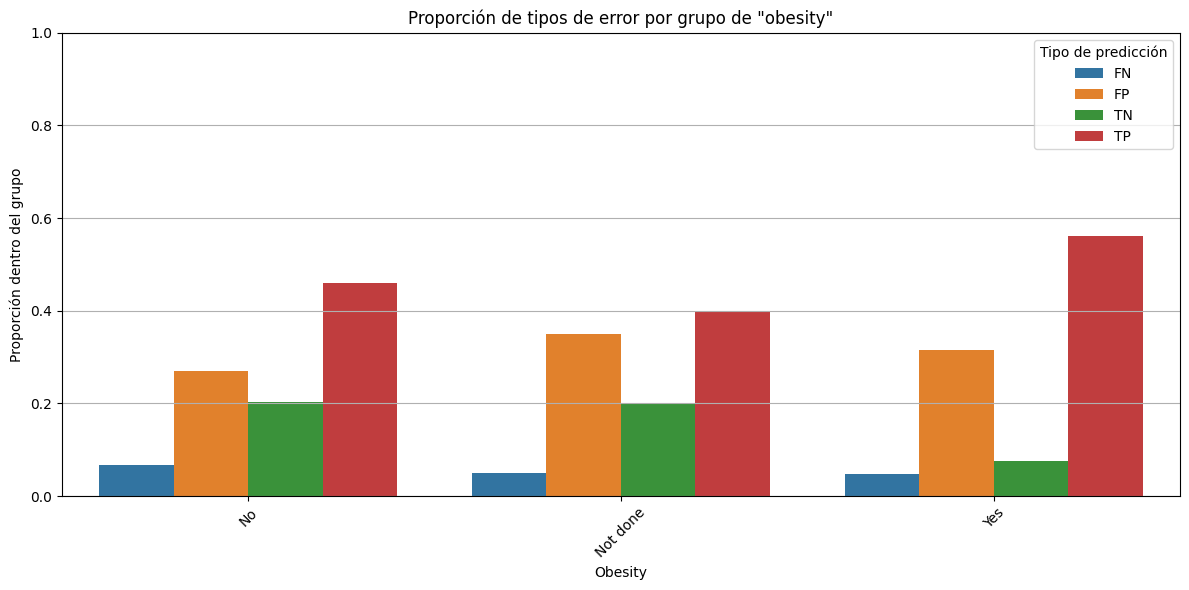

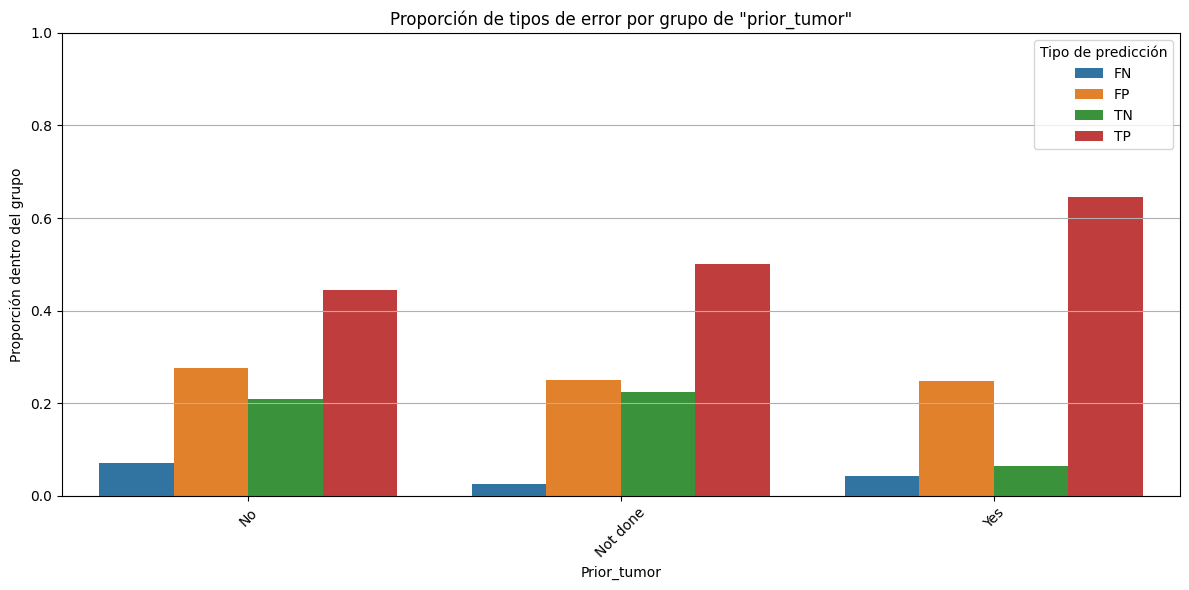

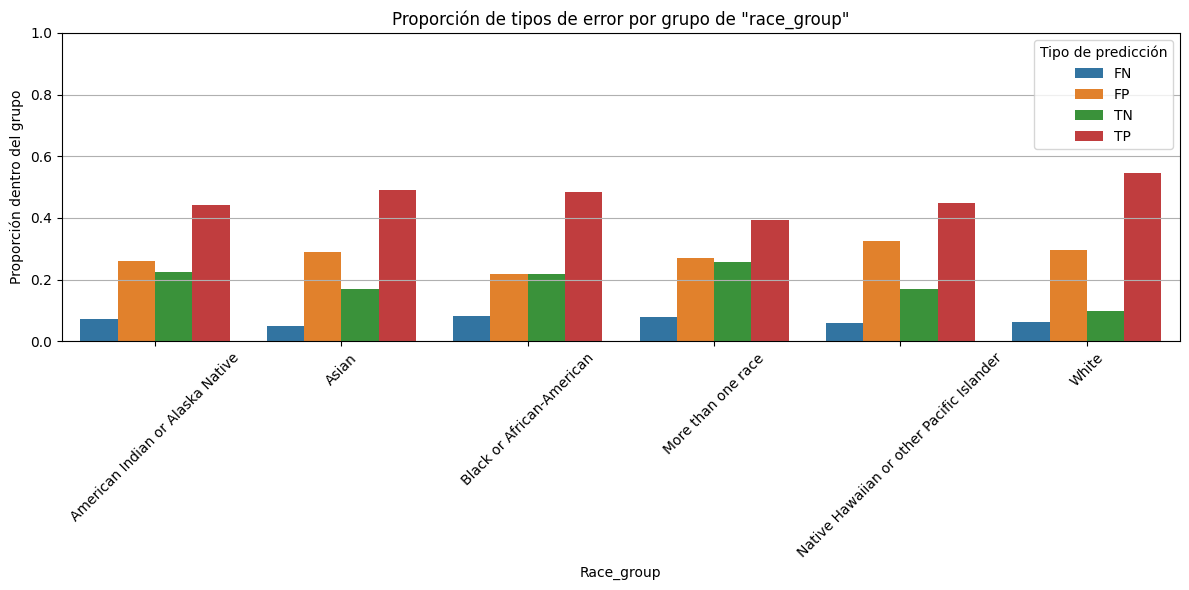

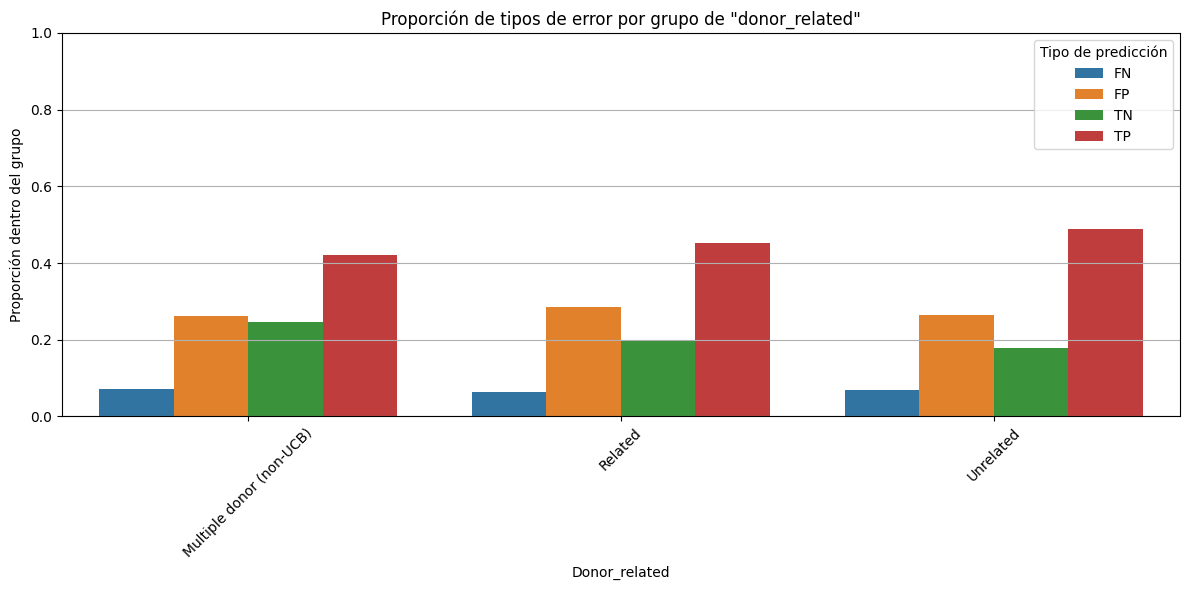

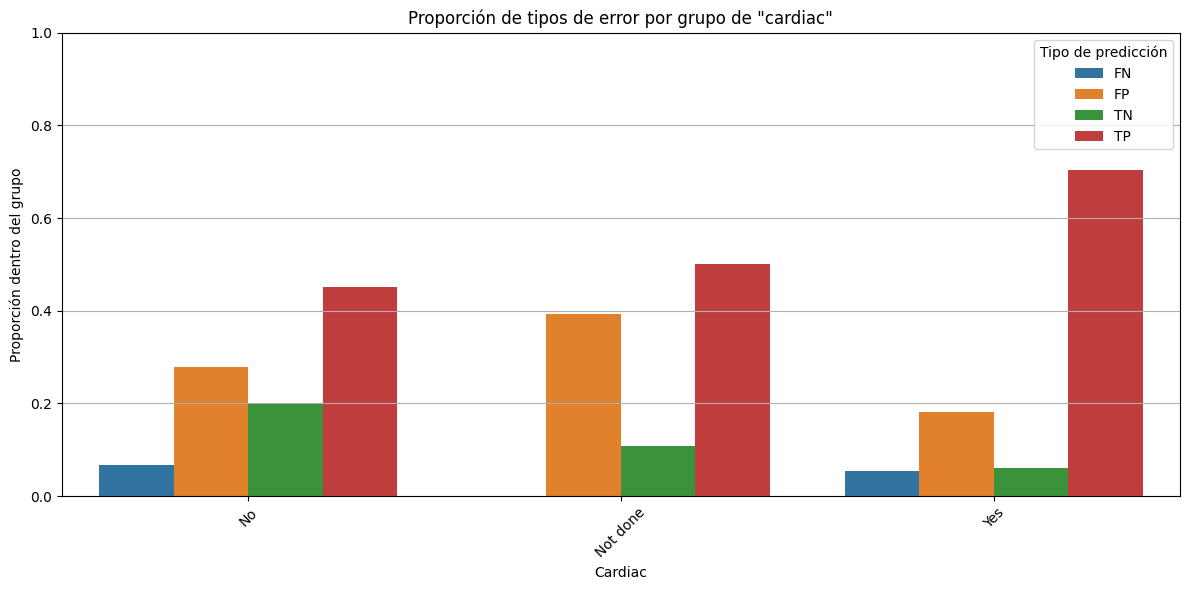

In [ ]:
# Analizar errores por grupo étnico
representar_errores_por_categoria(X_test, y_test, gb_final_pred, 'ethnicity')

# Analizar errores en función del peso del paciente.
representar_errores_por_categoria(X_test, y_test, gb_final_pred, 'obesity')

# Analizar errores en función de si ha tenido un tumor previo.
representar_errores_por_categoria(X_test, y_test, gb_final_pred, 'prior_tumor')

# Analizar errores en función de la raza del paciente
representar_errores_por_categoria(X_test, y_test, gb_final_pred, 'race_group')

# Analizar errores en función de si el donante es familiar o no
representar_errores_por_categoria(X_test, y_test, gb_final_pred, 'donor_related')

# Analizar errores en función de si el paciente tiene problemas cardiacos
representar_errores_por_categoria(X_test, y_test, gb_final_pred, 'cardiac')


/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_90266/1757632428.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_count = df.groupby([variable_categorica, 'tipo_error']).size().reset_index(name='count')
/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_90266/1757632428.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_group = error_count.groupby(variable_categorica)['count'].transform('sum')


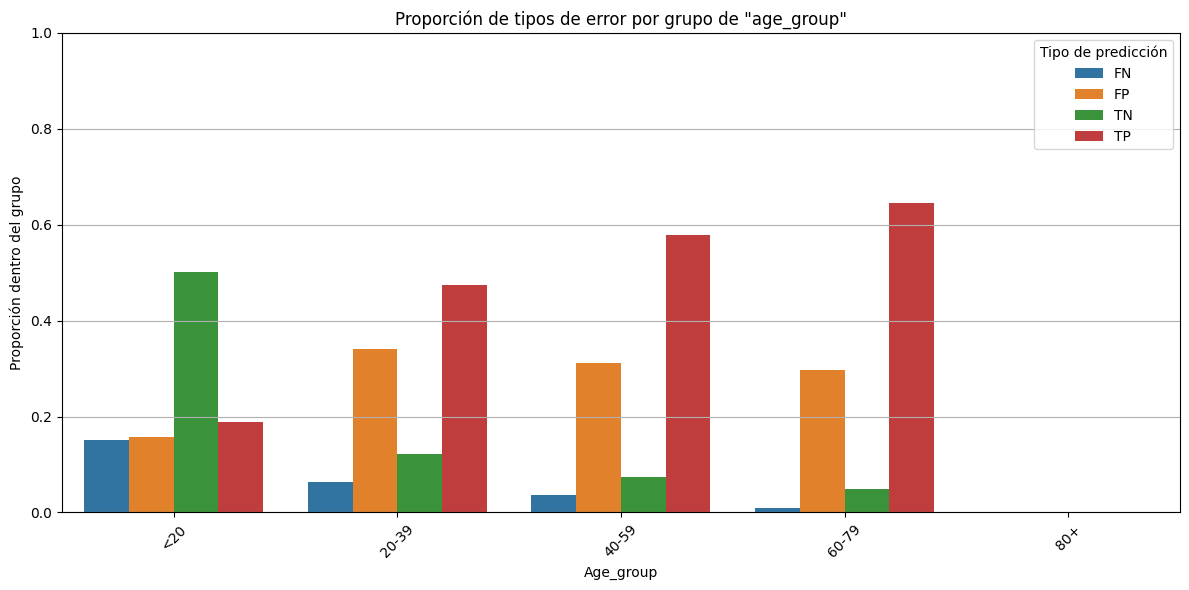

In [41]:
#Analizar en función de la edad del paciente
bins = [0, 20, 40, 60, 80, 100]
labels = ['<20', '20-39', '40-59', '60-79', '80+']
X_test['age_group'] = pd.cut(X_test['age_at_hct'], bins=bins, labels=labels, right=False)
representar_errores_por_categoria(X_test, y_test, gb_final_pred, 'age_group')